# Implementing a Genetic Algorithm

For now, we encode (as most commonly is done) an individual as a fixed-length vector of bits or Boolean values. If it contains real numbers, then we could use the implementation as done for single-state optimization methods and ES based on a normal distribution function.

In [181]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import random

def assessFitness(p):
    fitness = 0
    for i in range(len(p)):
        if(i%2==0 and p[i]==1):
            fitness = fitness + 10
        if(i%3==0 and p[i]==1):
            fitness = fitness - 3
        if(i%4==0 and p[i]==1):
            fitness = fitness + 2
        if(i%5==0 and p[i]==0):
            fitness = fitness + 20
        if(i%10==0 and p[i]==0):
            fitness = fitness - 30
    return fitness

def breed(P, F):
    Q = []
    for i in range(int(len(P)/2)):
        parent_a = selectParent(P, F)
        parent_b = selectParent(P, F)
        child_a, child_b = crossover(copy(parent_a), copy(parent_b))
        Q.append(mutate(child_a))
        Q.append(mutate(child_b))
    return Q

def selectParent(P, F):
    return selectWithReplacement(P)

def selectWithReplacement(P):
    return P[random.randint(0,len(P))-1]

def copy(individual):
    new_individual = list(individual)
    return new_individual

def crossover_split_half(parent_a, parent_b):
    child_a = parent_a[0:int(len(l1)/2)]
    child_a.extend(parent_b[int(len(l2)/2):])
    child_b = parent_b[0:int(len(l1)/2)]
    child_b.extend(parent_a[int(len(l2)/2):])
    return child_a, child_b

def crossover(parent_a, parent_b):
    return crossover_split_half(parent_a, parent_b)

def mutate(p, probability=None):
    if probability is None:
        probability = 1/len(p)
    for i in range(len(p)):
        if probability > random.uniform(0, 1):
            if(p[i] == 0):
                p[i] = 1
            else:
                p[i] = 0
    return p


In [182]:
def genetic_algorithm(P, iterations=100, maxFitness=None):
    best = None
    bestFitness = None
    bestHistory = []
    generation = 1
    while (generation <= iterations):
        allFitness = []
        for i in range(len(P)):
            fitness = assessFitness(P[i])
            allFitness.append(fitness)
            if best == None or fitness > bestFitness:
                best = P[i]
                bestFitness = fitness
                bestHistory.append(bestFitness)
        if(maxFitness is not None and bestFitness >= maxFitness):
            break
        P = breed(P, allFitness)
        generation = generation +1
    return best, bestFitness, generation-1, bestHistory

def random_init(size):
    P = []
    for i in range(size):
        p = [0] * 15
        P.append(mutate(p,0.5))
    return P

In [87]:
## Computing all solutions in a brute-force manner
def per(n):
    P = []
    for i in range(1<<n):
        s=bin(i)[2:]
        s='0'*(n-len(s))+s
        P.append(list(map(int,list(s))))
    return P

32768
[-26, -26, -26, -26, -26, -26, -26, -26, -26, -26]
[99, 99, 99, 99, 99, 99, 99, 99, 99, 99]


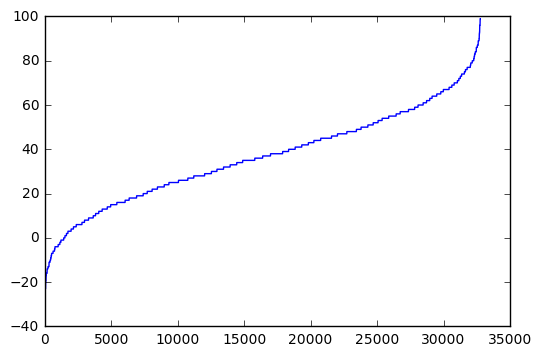

In [183]:
#Checking fitness of all solutions and print the 10 best and 10 worst
x = per(15)
values = []
for i in range(len(x)):
    values.append(assessFitness(x[i]))
values = sorted(values)
print(len(values))
print(values[0:10])
print(values[-10:])

plt.plot(values)
plt.show()

In [184]:
#Now compare with our genetic algorithm
P = random_init(10)
best, fit, gens, history = genetic_algorithm(P,maxFitness=99)
print("Best found: ", best)
print("Fitness of best individual: ", fit)
print("Required number of iterations: ", gens)
print("History of fitness changes: ", history)

Best found:  [1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1]
Fitness of best individual:  96
Required number of iterations:  100
History of fitness changes:  [64, 67, 77, 83, 86, 93, 96]


In [197]:
def do_halfCrossOverExperiment():
    allFitnesses = []
    allGenerations = []
    for i in range(1,20):
        P = random_init(10)
        best, fit, gens, history = genetic_algorithm(P,maxFitness=99)
        allFitnesses.append(fit)
        allGenerations.append(gens)
    for i in range(1,20):
        P = random_init(10)
        best, fit, gens, history = genetic_algorithm(P,iterations=50,maxFitness=99)
        allFitnesses.append(fit)
        allGenerations.append(gens)
    for i in range(1,20):
        P = random_init(10)
        best, fit, gens, history = genetic_algorithm(P,iterations=20,maxFitness=99)
        allFitnesses.append(fit)
        allGenerations.append(gens)
    return allFitnesses, allGenerations
allFitnesses, allGenerations = do_halfCrossOverExperiment()

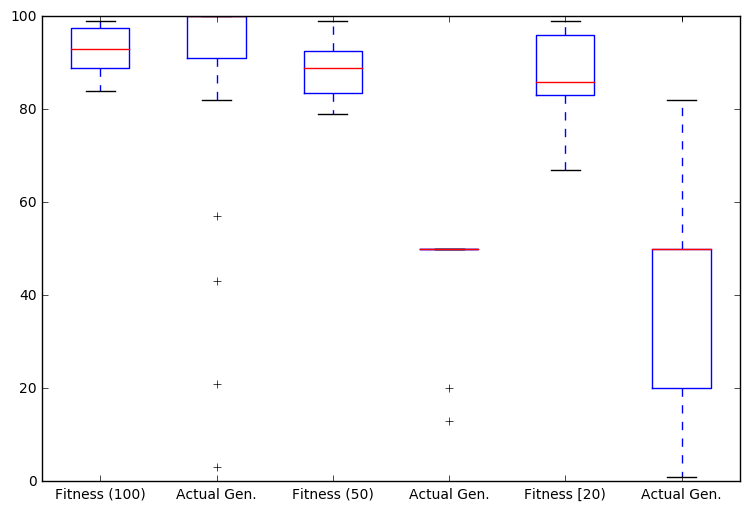

In [198]:
data = [allFitnesses[0:19],allGenerations[0:19],allFitnesses[20:39],allGenerations[20:39],allFitnesses[40:59],allGenerations[4:59]]
fig = plt.figure(1, figsize=(9, 6))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(data)
ax.set_xticklabels(['Fitness (100)', 'Actual Gen.', 'Fitness (50)', 'Actual Gen.', 'Fitness [20)', 'Actual Gen.'])
plt.show()

## Better Crossover Operations

The current solution just cuts the whole individual in half. The problem is that we might always miss (or cut away) good solutions when, for example, the fitness function favors connections in the center areas of an individual. Also, it is very unflexible. A better solution might be to crossover an area of a randomly chosen size. This is what we implement for now:

In [80]:
def onePointCrossover(parent_a, parent_b):
    #First we initialize our children based on the parents
    child_a = parent_a
    child_b = parent_b
    #Next, we randomly choose an index 
    crossBelowIndex = random.randint(1,len(parent_a)-1)
    if (crossBelowIndex != 1):
        #We exchange all genes in the individual from 1 till the index have been reached
        for i in xrange(1,crossBelowIndex):
            temp = child_a[i]
            child_a[i] = child_b[i]
            child_a[i] = temp
    return child_a, child_b

def crossover(parent_a, parent_b):
    return onePointCrossover(parent_a, parent_b)

In [195]:
def do_onePointCrossOverExperiment():
    allFitnesses_op = []
    allGenerations_op = []
    for i in range(1,20):
        P = random_init(10)
        best, fit, gens, history = genetic_algorithm(P,maxFitness=99)
        allFitnesses_op.append(fit)
        allGenerations_op.append(gens)
    for i in range(1,20):
        P = random_init(10)
        best, fit, gens, history = genetic_algorithm(P,iterations=50,maxFitness=99)
        allFitnesses_op.append(fit)
        allGenerations_op.append(gens)
    for i in range(1,20):
        P = random_init(10)
        best, fit, gens, history = genetic_algorithm(P,iterations=20,maxFitness=99)
        allFitnesses_op.append(fit)
        allGenerations_op.append(gens)
    return allFitnesses_op, allGenerations_op
allFitnesses_op, allGenerations_op = do_onePointCrossOverExperiment()

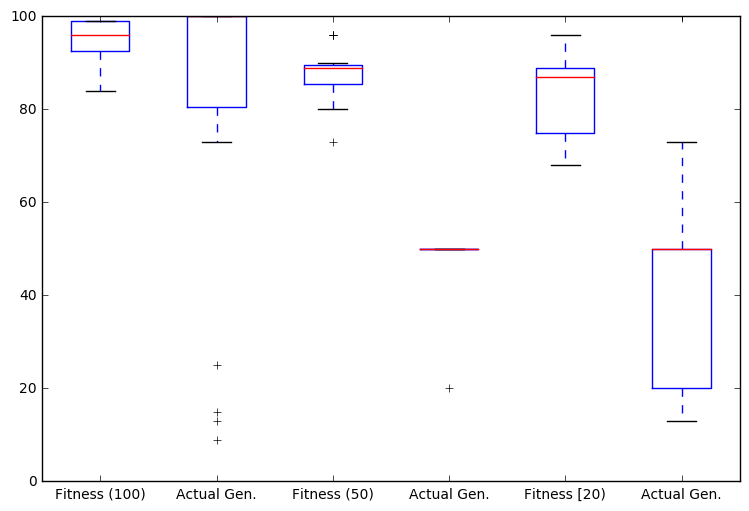

In [196]:
data = [allFitnesses_op[0:19],allGenerations_op[0:19],allFitnesses_op[20:39],allGenerations_op[20:39],allFitnesses_op[40:59],allGenerations_op[4:59]]
fig = plt.figure(1, figsize=(9, 6))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(data)
ax.set_xticklabels(['Fitness (100)', 'Actual Gen.', 'Fitness (50)', 'Actual Gen.', 'Fitness [20)', 'Actual Gen.'])
plt.show()

So, this is better, because it is not too strict. However, it still has drawbacks. On average, it splits somehow in between two individuals. Furthermore, there can be never an exchange between only the first and last elements. So, if our (unknown) fitness function favors those regions, this splitting is still insufficient. Moreover, we will always exchange the first elements and never keep them fixed, though this might be beneficial for the fitness score. So, let us improve this a bit more to gain more flexibility using the Two-Point Crossover:

In [139]:
def twoPointCrossover(parent_a, parent_b):
    #First we initialize our children based on the parents
    child_a = parent_a
    child_b = parent_b
    #Next, we randomly choose an index 
    index1 = random.randint(1,len(parent_a)-1)
    index2 = random.randint(1,len(parent_a)-1)
    
    #Make sure that index1 is always smaller than index2
    if(index1 > index2):
        temp = index1
        index1 = index2
        index2 = temp
        
    if (index1 != index2):
        #We exchange all genes in the individual from 1 till the index have been reached
        for i in range(index1,index2):
            temp = child_a[i]
            child_a[i] = child_b[i]
            child_a[i] = temp
    return child_a, child_b

def crossover(parent_a, parent_b):
    return twoPointCrossover(parent_a, parent_b)

In [188]:
def do_twoPointCrossOverExperiment():
    allFitnesses_tp = []
    allGenerations_tp = []
    for i in range(1,20):
        P = random_init(10)
        best, fit, gens, history = genetic_algorithm(P,maxFitness=99)
        allFitnesses_tp.append(fit)
        allGenerations_tp.append(gens)
    for i in range(1,20):
        P = random_init(10)
        best, fit, gens, history = genetic_algorithm(P,iterations=50,maxFitness=99)
        allFitnesses_tp.append(fit)
        allGenerations_tp.append(gens)
    for i in range(1,20):
        P = random_init(10)
        best, fit, gens, history = genetic_algorithm(P,iterations=20,maxFitness=99)
        allFitnesses_tp.append(fit)
        allGenerations_tp.append(gens)
    return allFitnesses_tp,allGenerations_tp
allFitnesses_tp,allGenerations_tp = do_twoPointCrossOverExperiment()

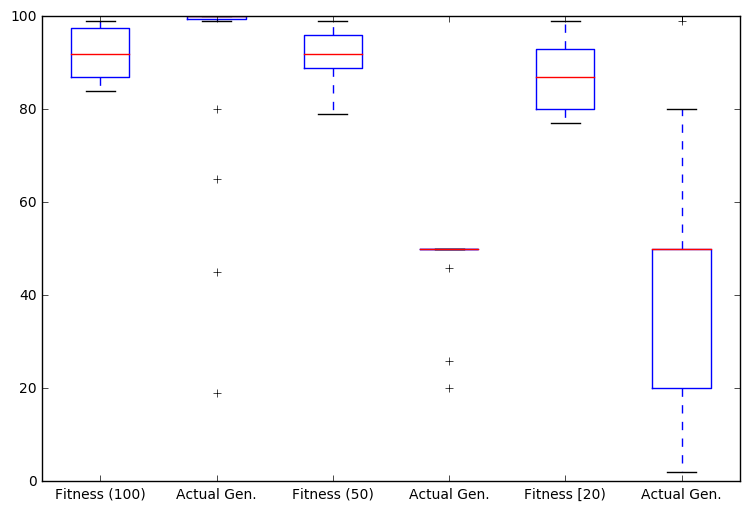

In [189]:
data = [allFitnesses_tp[0:19],allGenerations_tp[0:19],allFitnesses_tp[20:39],allGenerations_tp[20:39],allFitnesses_tp[40:59],allGenerations_tp[4:59]]
fig = plt.figure(1, figsize=(9, 6))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(data)
ax.set_xticklabels(['Fitness (100)', 'Actual Gen.', 'Fitness (50)', 'Actual Gen.', 'Fitness [20)', 'Actual Gen.'])
plt.show()

So, with this operation, we might exchange only the last genes or only the first genes or only genes in the middle. So, that is better. However, what if we want to exchange only the first *and* last genes? This still don't work with this solution. Also, we break more often long distances between genes (e.g., from index 1 to len(parent)/2) than short distances (e.g., between index 1 to 2). Again, we need something more flexible in certain kind of scenarios. We need the Uniform Crossover:

In [142]:
def uniformCrossover(parent_a, parent_b, proability=0.5):
    #First we initialize our children based on the parents
    child_a = parent_a
    child_b = parent_b
    #Next, we randomly choose an index 
    for i in range(1,len(parent_a)):
        if proability>=random.uniform(0, 1):
            temp = child_a[i]
            child_a[i] = child_b[i]
            child_a[i] = temp
    return child_a, child_b

def crossover(parent_a, parent_b):
    return uniformCrossover(parent_a, parent_b)

In [186]:
def do_uniformCrossOverExperiment():
    allFitnesses_u = []
    allGenerations_u = []
    for i in range(1,20):
        P = random_init(10)
        best, fit, gens, history = genetic_algorithm(P,maxFitness=99)
        allFitnesses_u.append(fit)
        allGenerations_u.append(gens)
    for i in range(1,20):
        P = random_init(10)
        best, fit, gens, history = genetic_algorithm(P,iterations=50,maxFitness=99)
        allFitnesses_u.append(fit)
        allGenerations_u.append(gens)
    for i in range(1,20):
        P = random_init(10)
        best, fit, gens, history = genetic_algorithm(P,iterations=20,maxFitness=99)
        allFitnesses_u.append(fit)
        allGenerations_u.append(gens)
    return allFitnesses_u, allGenerations_u
allFitnesses_u, allGenerations_u = do_uniformCrossOverExperiment()

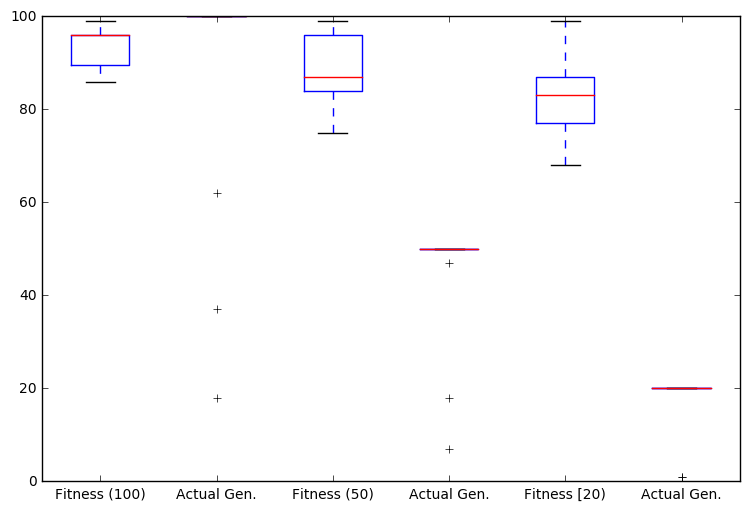

In [187]:
data = [allFitnesses_u[0:19],allGenerations_u[0:19],allFitnesses_u[20:39],allGenerations_u[20:39],allFitnesses_u[40:59],allGenerations_u[40:59]]
fig = plt.figure(1, figsize=(9, 6))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(data)
ax.set_xticklabels(['Fitness (100)', 'Actual Gen.', 'Fitness (50)', 'Actual Gen.', 'Fitness [20)', 'Actual Gen.'])
plt.show()

## Comparing all Crossover Operations

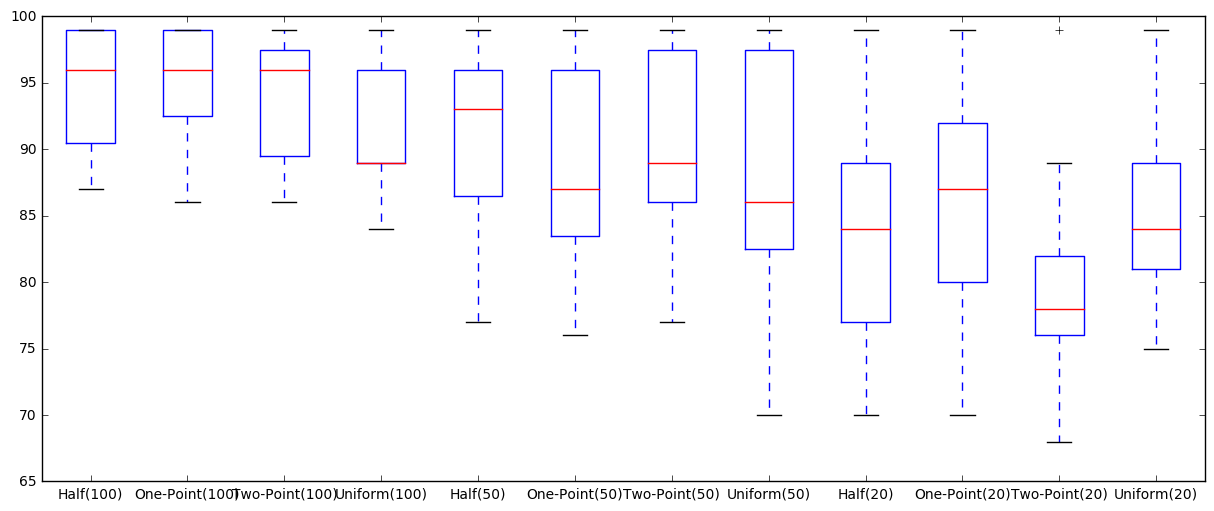

In [152]:
data_all = [allFitnesses[0:19],allFitnesses_op[0:19],allFitnesses_tp[0:19],allFitnesses_u[0:19],allFitnesses[20:39],allFitnesses_op[20:39],allFitnesses_tp[20:39],allFitnesses_u[20:39],allFitnesses[40:59],allFitnesses_op[40:59],allFitnesses_tp[40:59],allFitnesses_u[40:59]]
fig = plt.figure(1, figsize=(15, 6))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(data_all)
ax.set_xticklabels(['Half(100)', 'One-Point(100)', 'Two-Point(100)', 'Uniform(100)', 'Half(50)', 'One-Point(50)', 'Two-Point(50)', 'Uniform(50)','Half(20)', 'One-Point(20)', 'Two-Point(20)', 'Uniform(20)'])
plt.show()

Note that the comparison of the plots above can vary largely. Which crossover operations works best is problem dependent. So, there is no silver bullet.

## Uniform Crossover Among K Vectors

In [178]:
#first we need a function to randomly shuffle a single vector

def shuffle(vec):
    for i in range(len(vec)-1,0,-1):
        j = random.randint(0,i)
        temp = vec[i]
        vec[i] = vec[j]
        vec[j] = temp
    return vec

testvector = [1,1,1,0,0,0]

for i in range(5):
    print(shuffle(testvector))

[0, 1, 1, 0, 0, 1]
[0, 0, 1, 1, 0, 1]
[1, 0, 0, 1, 0, 1]
[1, 0, 0, 1, 0, 1]
[0, 1, 1, 0, 1, 0]


### For homework: How to do random shuffle over the k vectors?

In [179]:
#Help: you should start with the following method parameters
def uniformCrossoverWithKVectors(vectorsToCross, prabilityOfSwap=0.01):
    #???
    return vectorsToCross


## Better Fitness Selection
### Let us start with fitness-proportionate selection

In [185]:
def fitnessProportionateSelection(P, F):
    #this is zero based, so we start from index 1
    for i in range(1,len(P)):
        F[i] = F[i]+F[i-1]
    n = random.uniform(0,F[len(P)-1])
    #this could be done smarter... how?
    for i in range(1,len(P)):
        if F[i-1] < n and n <= F[i]:
            return P[i]
    return P[0]

def selectParent(P, F):
    return fitnessProportionateSelection(P, F)

### For homework: Implement Stochastic Universal Sampling

In [199]:
def fitnessStochasticProportionateSelection(P, F):
    #?
    return 0